In [202]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json

In [2]:
file = pd.read_csv("Desktop/globalterrorismdb_0617dist.csv", encoding = "latin-1")

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2723: DtypeWarning: Columns (4,6,31,33,53,61,62,63,76,79,90,92,94,96,114,115,121) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


# WEAPON TYPE

In [277]:
stacked_bar = file[['iyear', 'nkill', 'weaptype1_txt', 'region_txt']]

In [278]:
clean_stacked_bar = stacked_bar.dropna()

In [279]:
nkill = stacked_bar['nkill'].values
np.mean(np.isnan(nkill))

0.056835926034634575

In [189]:
groupby_sb = clean_stacked_bar.groupby(['weaptype1_txt', 'iyear']).sum()

In [190]:
clean_gb_sb = groupby_sb[groupby_sb.nkill != 0]

In [191]:
clean_gb_sb.head()

nkill
weaptype1_txt iyear       
Biological    2000     2.0
              2001     7.0
Chemical      1973     1.0
              1977     1.0
              1979     1.0

In [192]:
def trick(date):
    return 'new Date('+str(int(date))+',0)'

In [193]:
data = []

for i in set(clean_stacked_bar['weaptype1_txt'].values):
    data.append({
        'type': "stackedColumn100",
        'name': str(i),
        'showInLegend': True,
        'xValueFormatString': "YYYY",
        'yValueFormatString': "#,##0\"%\"",
        'dataPoints': [dict(x=trick(k), y=int(v)) for k, v in clean_gb_sb.loc[i].to_dict()['nkill'].items()]
    })

In [61]:
[dict(x=k, y=int(v)) for k, v in clean_gb_sb.loc[1].to_dict()['nkill'].items()]

[{'x': 2000, 'y': 2}, {'x': 2001, 'y': 7}]

In [194]:
with open('stacked_bar.json', 'w') as outfile:  
    json.dump(data, outfile)

# EXPLOSIF VS FIRE WEAPON

In [287]:
target_ef = clean_stacked_bar.groupby(['weaptype1_txt', 'iyear']).agg(['sum', 'count'])['nkill']

In [317]:
bombvsfireamr = target_ef.loc[['Explosives/Bombs/Dynamite', 'Firearms']]

In [319]:
bombvsfireamr.head()

sum  count
weaptype1_txt             iyear              
Explosives/Bombs/Dynamite 1970    97.0    320
                          1971    82.0    207
                          1972   260.0    167
                          1973    80.0    141
                          1974   270.0    263

In [329]:
eff = pd.DataFrame(bombvsfireamr['sum'].values / bombvsfireamr['count'].values, columns=['eff'], index=bombvsfireamr.index)
eff.head()

eff
weaptype1_txt             iyear          
Explosives/Bombs/Dynamite 1970   0.303125
                          1971   0.396135
                          1972   1.556886
                          1973   0.567376
                          1974   1.026616

In [333]:
bombvsfireamr_points = []
for i in ['Explosives/Bombs/Dynamite', 'Firearms']:
    bombvsfireamr_points.append({
    'type': "line",
    'axisYType': "secondary",
    'name': i,
    'showInLegend': True,
    'markerSize': 0,
    'yValueFormatString': "$#,###k",
    'dataPoints': [dict(x=trick(k), y=v) for k, v in eff.loc[i].to_dict()['eff'].items()]
    })

In [334]:
with open('/Users/Nicolas/Desktop/bombvsfireamrm.json', 'w') as outfile:  
    json.dump(bombvsfireamr_points, outfile)

In [476]:
eff_decade = eff.reset_index(level='weaptype1_txt').drop(['weaptype1_txt'], axis=1)
bomb_decade = pd.DataFrame([int(i/10)*10 for i in eff_decade.index], columns=['decade'], index=eff_decade.index)

In [479]:
bomb_df = eff_decade.join(bomb_decade).groupby(['decade']).agg(['mean'])['eff']

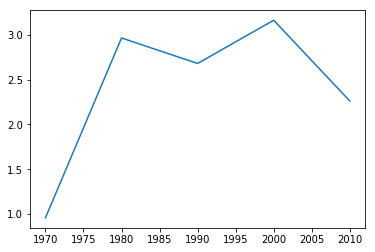

In [481]:
plt.plot(bomb_df)

# CIVIL BOMB

In [346]:
cb = file[['iyear', 'nkill', 'weaptype1_txt', 'targtype1_txt']]
civil = cb[cb['targtype1_txt']=='Private Citizens & Property']
clean_civil = civil.dropna()
clean_civil.head()

,iyear,nkill,weaptype1_txt,targtype1_txt
0,1970,1.0,Unknown,Private Citizens & Property
28,1970,0.0,Explosives/Bombs/Dynamite,Private Citizens & Property
29,1970,0.0,Incendiary,Private Citizens & Property
46,1970,0.0,Explosives/Bombs/Dynamite,Private Citizens & Property
58,1970,0.0,Explosives/Bombs/Dynamite,Private Citizens & Property


In [422]:
agg_civil = clean_civil.groupby(['iyear', 'weaptype1_txt']).agg(['count'])['nkill']

In [423]:
n_agg_civil = agg_civil.reset_index(level='weaptype1_txt')

In [424]:
c_agg_civil = n_agg_civil[n_agg_civil['weaptype1_txt']=='Explosives/Bombs/Dynamite']

In [413]:
c_agg_civil.head()

,weaptype1_txt,count
iyear,,
1970,Explosives/Bombs/Dynamite,29
1971,Explosives/Bombs/Dynamite,9
1972,Explosives/Bombs/Dynamite,33
1973,Explosives/Bombs/Dynamite,23
1974,Explosives/Bombs/Dynamite,26


In [419]:
ct = clean_civil.groupby(['iyear']).agg(['count'])['nkill']
#ct = ct.rename(index=str, columns={"count": "count_sum"})

In [453]:
new = pd.DataFrame(c_agg_civil['count'].values/ct['count'].values, columns=['civil_ratio'], index=c_agg_civil.index)

In [460]:
decade = pd.DataFrame([int(i/10)*10 for i in new.index], columns=['decade'], index=new.index)

decade_df = decade.join(new).groupby(['decade']).agg(['mean'])['civil_ratio']

In [462]:
decade_df

,mean
decade,
1970,0.338784
1980,0.368285
1990,0.265691
2000,0.470623
2010,0.608282


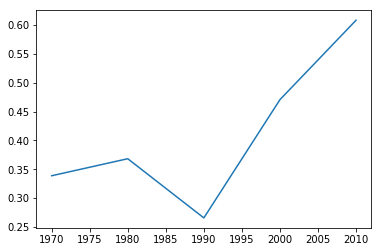

In [463]:
plt.plot(decade_df)

In [482]:
civil_bomb_points = [dict(x=trick(y), y=row[0]) for y, row in new.iterrows()]

In [431]:
with open('/Users/Nicolas/Desktop/civil_bomb_points.json', 'w') as outfile:  
    json.dump(civil_bomb_points, outfile)

# BUBBLE CIVIL

In [483]:
clean_civil.head()

,iyear,nkill,weaptype1_txt,targtype1_txt
0,1970,1.0,Unknown,Private Citizens & Property
28,1970,0.0,Explosives/Bombs/Dynamite,Private Citizens & Property
29,1970,0.0,Incendiary,Private Citizens & Property
46,1970,0.0,Explosives/Bombs/Dynamite,Private Citizens & Property
58,1970,0.0,Explosives/Bombs/Dynamite,Private Citizens & Property


In [ ]:
agg_civil = clean_civil.groupby(['iyear', 'weaptype1_txt']).agg(['count'])['nkill']

# NB KILL

In [195]:
groupby_nkill = clean_stacked_bar.groupby(['iyear']).sum()

In [207]:
nkill_points = [dict(x=trick(k), y=int(v)) for k, v in groupby_nkill['nkill'].to_dict().items()]

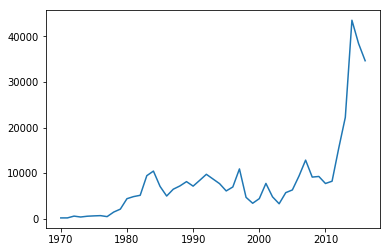

In [200]:
plt.plot(groupby_nkill)

In [209]:
with open('/Users/Nicolas/Desktop/nkill_points.json', 'w') as outfile:  
    json.dump(nkill_points, outfile)

# BY REGION

In [263]:
groupby_br = clean_stacked_bar.groupby(['region_txt', 'iyear']).sum()

In [256]:
set(clean_stacked_bar['region_txt'])

{'Australasia & Oceania',
 'Central America & Caribbean',
 'Central Asia',
 'East Asia',
 'Eastern Europe',
 'Middle East & North Africa',
 'North America',
 'South America',
 'South Asia',
 'Southeast Asia',
 'Sub-Saharan Africa',
 'Western Europe'}

In [272]:
data_region = []

for i in set(clean_stacked_bar['region_txt'].values):
    data_region.append({
                    'type': "stackedArea",
                    'showInLegend': True,
                    'toolTipContent': "<span style=\"color:#4F81BC\"><strong>{name}: </strong></span> {y}",
                    'name': str(i),
                    'dataPoints': [dict(x=trick(k), y=int(v)) for k, v in groupby_br.loc[i].to_dict()['nkill'].items()]
                })

In [274]:
with open('/Users/Nicolas/Desktop/data_region.json', 'w') as outfile:  
    json.dump(data_region, outfile)

# BUBBLE

In [212]:
pop = pd.read_csv("/Users/Nicolas/Desktop/API_SP.POP.TOTL_DS2_fr_csv_v2/API_SP.POP.TOTL_DS2_fr_csv_v2.csv")

In [227]:
pop_dict = pop.sum().to_dict()
clean_pop = []
for i in range(1970, 2017):
    clean_pop.append(dict(x=trick(i), y=int(pop_dict[str(i)])))

In [229]:
with open('/Users/Nicolas/Desktop/pop.json', 'w') as outfile:  
    json.dump(clean_pop, outfile)

In [235]:
target = file[['nkill', 'targtype1_txt']]

In [241]:
target_gb = target.groupby(['targtype1_txt']).agg(['sum', 'count'])['nkill']

In [249]:
target_gb

,sum,count
targtype1_txt,,
Abortion Related,10.0,259
Airports & Aircraft,3743.0,1223
Business,22061.0,18403
Educational Institution,3624.0,3992
Food or Water Supply,281.0,265
Government (Diplomatic),2657.0,3255
Government (General),24810.0,19429
Journalists & Media,1403.0,2597
Maritime,1171.0,287


In [250]:
target_points = []
for index, row in target_gb.iterrows():
    x = np.log(row['sum'])
    y = np.log(row['count'])
    target_points.append(dict(x=x, y=y, z=row['sum']/row['count'], name=index))

In [251]:
target_points

[{'name': 'Abortion Related',
  'x': 2.3025850929940459,
  'y': 5.5568280616995374,
  'z': 0.038610038610038609},
 {'name': 'Airports & Aircraft',
  'x': 8.2276427079044296,
  'y': 7.1090621356871724,
  'z': 3.0605069501226492},
 {'name': 'Business',
  'x': 10.001566622695764,
  'y': 9.8202689737851951,
  'z': 1.1987719393577134},
 {'name': 'Educational Institution',
  'x': 8.1953336671628705,
  'y': 8.2920476374313541,
  'z': 0.90781563126252507},
 {'name': 'Food or Water Supply',
  'x': 5.6383546693337454,
  'y': 5.579729825986222,
  'z': 1.060377358490566},
 {'name': 'Government (Diplomatic)',
  'x': 7.8849529457598138,
  'y': 8.0879475546426693,
  'z': 0.81628264208909374},
 {'name': 'Government (General)',
  'x': 10.119002076685847,
  'y': 9.8745220742431137,
  'z': 1.2769571259457513},
 {'name': 'Journalists & Media',
  'x': 7.246368080102461,
  'y': 7.8621122116627484,
  'z': 0.54023873700423564},
 {'name': 'Maritime',
  'x': 7.0656133635977172,
  'y': 5.6594822157596214,
  'z':

In [252]:
with open('/Users/Nicolas/Desktop/target_points.json', 'w') as outfile:  
    json.dump(target_points, outfile)